In [1]:
# Load all parameters as tracked by dvc
import yaml

with open("params.yaml", 'r') as fd:
    PARAMS = yaml.safe_load(fd)

In [2]:
import numpy as np
import tensorflow as tf
tf.config.optimizer.set_jit(PARAMS['training']['jit_compile'])
# Important for SUMO-* servers
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        gpu = gpus[PARAMS['gpu_num']]
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
        tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

import tensorflow_probability as tfp
tfd = tfp.distributions

print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU
2.6.0


In [3]:
FOLD = 0

In [92]:
from sklearn.pipeline import make_pipeline, Pipeline
from skopt.space import Real, Categorical, Integer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA

def prep_train_val(fold):
    data_train = tf.data.experimental.load(f'artifacts/train_dataset_{fold}')
    data_val = tf.data.experimental.load(f'artifacts/val_dataset_{fold}')

    X_train, y_train = zip(*list(data_train.as_numpy_iterator()))
    X_val, y_val = zip(*list(data_val.as_numpy_iterator()))

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
class MSKFold:
    def split(self, X, y, groups=None):
        for fold in range(fold):
            X_train, X_val = prep_train_val(fold)
            
            test = np.isin(X==X_train, axis=0)
            assert test.shape[0] == X
            ind_train = np.where(np.all(X==X_train, axis=0))
            
            yield
            

    def get_n_splits(self, X, y, groups=None):
        return 5



def evaluate_for_fold(fold, random_state=20211115):
    data_train = tf.data.experimental.load(f'artifacts/train_dataset_{fold}')
    data_train_ = tf.data.experimental.load(f'artifacts/val_dataset_{fold}')
    data_val = tf.data.experimental.load(f'artifacts/test_dataset_{fold}')

    X_train, y_train = zip(*list(data_train.as_numpy_iterator()))
    X_train_, y_train_ = zip(*list(data_train_.as_numpy_iterator()))
    X_val, y_val = zip(*list(data_val.as_numpy_iterator()))

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train_ = np.array(X_train_)
    y_train_ = np.array(y_train_)
    X_train = np.concatenate((X_train, X_train_), axis=0)
    y_train = np.concatenate((y_train, y_train_), axis=0)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    X_train, y_train = RandomUnderSampler(random_state=random_state).fit_resample(X_train, y_train)
    
    clf = Pipeline([
        ('pca', PCA(n_components=10)),
        ('clf', LogisticRegression(max_iter=10000, class_weight='balanced', random_state=random_state, solver='saga'))
    ])
    # this is our parameter grid
    param_grid = {
        'clf__penalty': ['l2', 'l1', 'none'],
        'clf__C': (1e-8, 100.0, 'log-uniform'),
        #'clf__l1_ratio': (0.0, 1.0, 'uniform'),
        'pca__n_components': Integer(1, X_train.shape[-1], 'uniform')
    }

    opt = BayesSearchCV(
        clf,
        param_grid,
        n_iter=50,
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )

    opt.fit(X_train, y_train)

    preds = opt.predict(X_val)
    return roc_auc_score(y_val, preds), opt

In [53]:

auroc, opt = zip(*[evaluate_for_fold(fold) for fold in range(5)])

KeyboardInterrupt: 

In [40]:
np.mean(auroc)

0.6025709710621117

In [93]:
auroc, opt = evaluate_for_fold(0)

/home/sumo/lwerthen/miniconda3/envs/tf2.4/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/sumo/lwerthen/miniconda3/envs/tf2.4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


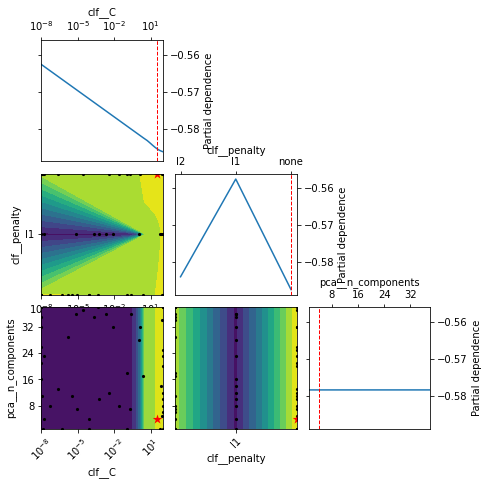

In [94]:
from skopt.plots import plot_objective, plot_histogram

_ = plot_objective(opt.optimizer_results_[0],
                   #dimensions=["penalty", "C", "l1_ratio", "PCA"],
                   n_minimum_search=int(1e8))

In [95]:
auroc

0.5826724188590162

In [65]:
fold=0
data_train = tf.data.experimental.load(f'artifacts/train_dataset_{fold}')
data_train_ = tf.data.experimental.load(f'artifacts/val_dataset_{fold}')
data_val = tf.data.experimental.load(f'artifacts/test_dataset_{fold}')

X_train, y_train = zip(*list(data_train.as_numpy_iterator()))
X_train_, y_train_ = zip(*list(data_train_.as_numpy_iterator()))
X_val, y_val = zip(*list(data_val.as_numpy_iterator()))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_train_ = np.array(X_train_)
y_train_ = np.array(y_train_)
X_train = np.concatenate((X_train, X_train_), axis=0)
y_train = np.concatenate((y_train, y_train_), axis=0)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [86]:
opt.score(X_val, y_val)

0.8743450900043904

In [74]:
opt.cv_results_

{'mean_fit_time': array([ 1.02729983,  0.7527072 , 28.64303684,  0.5572681 ,  0.83947644,
         1.0607286 ,  0.95712519, 34.16093979,  5.06302452,  1.13832417,
         0.37706695,  0.39083629,  0.60397282,  0.78845716,  1.37250924]),
 'std_fit_time': array([6.00462472e-02, 3.53169448e-02, 4.13401942e+00, 3.52939072e-02,
        3.69492219e-02, 1.70864826e-02, 3.48043953e-02, 1.11914051e+01,
        8.84304488e-01, 3.43394021e-02, 7.56537523e-03, 2.46635292e-02,
        1.76769122e-02, 3.08527132e-02, 4.00872045e-02]),
 'mean_score_time': array([0.00532541, 0.00387168, 0.00673103, 0.00464067, 0.00497084,
        0.00749612, 0.00588093, 0.00754442, 0.00691514, 0.00612745,
        0.00420308, 0.00377359, 0.00470734, 0.00647864, 0.00676289]),
 'std_score_time': array([0.00053251, 0.00045867, 0.00102956, 0.00037099, 0.00063005,
        0.00059496, 0.00044687, 0.00045367, 0.0006779 , 0.00049676,
        0.00021408, 0.00036421, 0.00033573, 0.00051541, 0.0003596 ]),
 'param_clf__C': masked